In [1]:
import tarfile
import pandas as pd
import os
import json
from itertools import islice
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import os


In [2]:
# 동적으로 구성할 디렉토리와 파일명
base_dir = 'C:/Project/RAG연구동향분석/250409'  # 여기를 바꿔서 동적으로 사용

In [3]:
df = pd.read_parquet('C:/Project/RAG연구동향분석/데이터/dblp_v14_filtered.parquet')

In [4]:
# references 열이 빈 리스트가 아닌 행만 필터링
filtered_df = df[df['references'].apply(lambda x: len(x) > 0 if isinstance(x, (list, np.ndarray)) else False)]

# 결과 확인
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after filtering: {len(filtered_df)}")
print(f"Number of rows removed: {len(df) - len(filtered_df)}")

df = filtered_df.copy()

Original number of rows: 5259857
Number of rows after filtering: 3273155
Number of rows removed: 1986702


In [5]:
ai_keywords = ["artificial intelligence", "AI", "machine learning", "deep learning", 
                  "neural network", "data mining", "analytics", "big data", "predictive model"]


In [6]:
mis_keywords = ["management", "business", "organization", "corporate", "entrepreneurship", "marketing", "finance", "strategy", "operations"]

# 중복 제거
mis_keywords = list(set(mis_keywords))

In [7]:
# title과 keywords를 소문자로 변환
df['title_lower'] = df['title'].str.lower()
df['keywords_lower'] = df['keywords'].apply(lambda x: [k.lower() if isinstance(k, str) else k for k in x])

# 키워드 리스트도 소문자로 변환
rag_keywords_lower = [k.lower() for k in ai_keywords]
business_keywords_lower = [k.lower() for k in mis_keywords]

In [8]:
# RAG 키워드 포함 여부 확인 (title 열에만)
# 'title_lower' 열에서 rag_keywords_lower에 포함된 키워드가 하나라도 있는지 확인합니다.
rag_mask = df['title_lower'].apply(lambda x: any(keyword in str(x) for keyword in rag_keywords_lower))

# 경영 키워드 포함 여부 확인 (title 열에만)
# 'title_lower' 열에서 business_keywords_lower에 포함된 키워드가 하나라도 있는지 확인합니다.
business_mask = df['title_lower'].apply(lambda x: any(keyword in str(x) for keyword in business_keywords_lower))

# 두 마스크를 AND 연산으로 결합 (title 열 기준: RAG 관련 AND 경영 관련)
# RAG 관련 키워드와 경영 관련 키워드가 모두 'title_lower' 열에 포함된 경우만 True가 됩니다.
combined_mask = rag_mask & business_mask

In [9]:
# combined_mask를 사용하여 데이터프레임 필터링
df_combined = df[combined_mask].copy()

# 필터링된 데이터프레임의 정보 확인
print(f"\n총 {len(df_combined)}개의 논문이 제목에 AI 및 경영 관련 키워드를 모두 포함합니다.")
print("\n제목에 AI 및 경영 관련 키워드를 모두 포함하는 논문 (샘플):")
print(df_combined.head())


총 12076개의 논문이 제목에 AI 및 경영 관련 키워드를 모두 포함합니다.

제목에 AI 및 경영 관련 키워드를 모두 포함하는 논문 (샘플):
                             id  \
1749   53e9b469b7602d9703f6a1cc   
3228   56d8f562dabfae2eee8fc563   
6627   53e9b082b7602d9703ae965c   
22356  53e997d1b7602d9701fc1f53   
22758  53e997d7b7602d9701fcbe27   

                                                   title  year  n_citation  \
1749   Deriving Enterprise Engineering and Integratio...  2004           8   
3228   Differentiated waiting time management accordi...  2015           0   
6627   Fast multiresolution image operations in the w...  2003          39   
22356  Data Mining Support in Database Management Sys...  2000          18   
22758     Active performance management in supply chains  2004          20   

                                                   venue  \
1749   INTERNATIONAL FEDERATION FOR INFORMATION PROCE...   
3228                       Annals of Operations Research   
6627   IEEE Transactions on Visualization and Compute... 

In [11]:
# 1. 상위 MIS 학술지 목록 정의
top_mis_journals = [
    "Decision Support Systems",
    "European Journal of Information Systems",
    "Information & Management",
    "Information and Organization",
    "Information Systems Journal",
    "Information Systems Research",
    "Journal of the AIS",
    "Journal of Information Technology",
    "Journal of MIS",
    "Journal of Strategic Information Systems",
    "MIS Quarterly"
]

# 2. 'venue' 열의 값이 상위 학술지 목록에 포함되는 행만 필터링
# isin() 함수는 'venue' 열의 각 값이 top_mis_journals 리스트에 있는지 확인하여 boolean 마스크를 반환합니다.
mis_papers_mask = df_combined['venue'].isin(top_mis_journals)

# 위에서 생성된 boolean 마스크를 사용하여 데이터프레임 필터링
df_mis_top_journals = df_combined[mis_papers_mask].copy() # .copy()를 사용하여 SettingWithCopyWarning 방지

# 3. 결과 확인
print(f"총 {len(df_mis_top_journals)}개의 논문이 상위 MIS 학술지에서 발견되었습니다.")

# 필터링된 데이터프레임의 처음 몇 행을 출력하여 확인
print("\n상위 MIS 학술지에 게재된 논문 (샘플):")
print(df_mis_top_journals.head())

# 필터링된 데이터프레임에 포함된 학술지 목록 확인 (선택 사항)
# print("\n필터링된 논문들의 학술지 목록:")
# print(df_mis_top_journals['venue'].unique())

총 126개의 논문이 상위 MIS 학술지에서 발견되었습니다.

상위 MIS 학술지에 게재된 논문 (샘플):
                              id  \
110500  53e99931b7602d970216f7a9   
123351  53e99967b7602d97021a9833   
125838  53e9996fb7602d97021b3f14   
153733  53e999e7b7602d970222f1f3   
269287  53e99ba2b7602d970244a128   

                                                    title  year  n_citation  \
110500  Predicting corporate bankruptcy using a self-o...  2011         121   
123351  Liquidity management with fuzzy qualitative co...  1995          19   
125838  Integrated value chains and their implications...  2000         169   
153733  Impact of psychological traits on user perform...  2012          20   
269287  Integrating web-based data mining tools with b...  2003         150   

                           venue  \
110500  Decision Support Systems   
123351  Decision Support Systems   
125838  Decision Support Systems   
153733  Decision Support Systems   
269287  Decision Support Systems   

                               

In [12]:
df_mis_top_journals.head()

,id,title,year,n_citation,venue,keywords,fos.name,references,title_lower,keywords_lower
110500,53e99931b7602d970216f7a9,Predicting corporate bankruptcy using a self-o...,2011,121,Decision Support Systems,[self organizing map],"[Data mining, Computer science, Regression ana...","[53e9996fb7602d97021b20ff, 53e999cbb7602d97022...",predicting corporate bankruptcy using a self-o...,[self organizing map]
123351,53e99967b7602d97021a9833,Liquidity management with fuzzy qualitative co...,1995,19,Decision Support Systems,"[probabilistic judgment, simple recourse, fuzz...","[Market liquidity, Data mining, Computer scien...","[53e99dbfb7602d9702681c76, 53e9a96db7602d97032...",liquidity management with fuzzy qualitative co...,"[probabilistic judgment, simple recourse, fuzz..."
125838,53e9996fb7602d97021b3f14,Integrated value chains and their implications...,2000,169,Decision Support Systems,"[business transactions, change management, bus...","[New business development, Business value, Bus...","[53e9984bb7602d970207b92e, 53e99a3cb7602d97022...",integrated value chains and their implications...,"[business transactions, change management, bus..."
153733,53e999e7b7602d970222f1f3,Impact of psychological traits on user perform...,2012,20,Decision Support Systems,"[user performance, call center information sys...","[Organizational performance, Organization deve...","[53e9b2abb7602d9703d544f1, 53e998c7b7602d97020...",impact of psychological traits on user perform...,"[user performance, call center information sys..."
269287,53e99ba2b7602d970244a128,Integrating web-based data mining tools with b...,2003,150,Decision Support Systems,"[business intelligence, web-based data mining,...","[Data science, Data mining, Computer science, ...","[53e997f9b7602d9702003a02, 53e99960b7602d97021...",integrating web-based data mining tools with b...,"[business intelligence, web-based data mining,..."


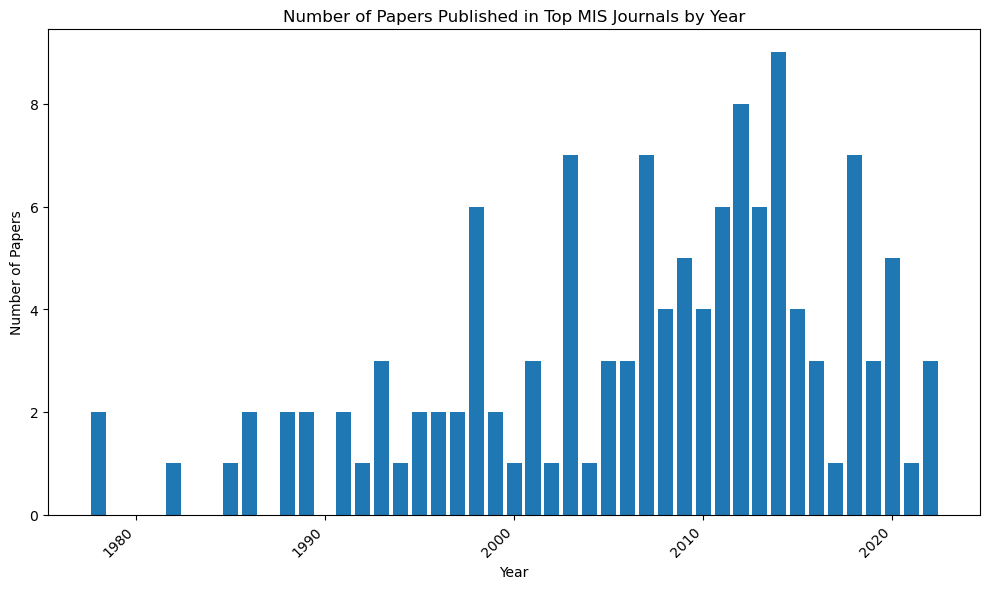

In [13]:
import matplotlib.pyplot as plt

# 'year' 열을 기준으로 논문 수 집계
year_counts = df_mis_top_journals['year'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))  # 그래프 크기 설정 (가로 10, 세로 6)
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Number of Papers Published in Top MIS Journals by Year")
plt.xticks(rotation=45, ha="right")  # x축 레이블을 45도 회전하여 겹치지 않게 표시
plt.tight_layout()  # 레이아웃 조정하여 요소들이 잘 표시되도록 함
plt.show()

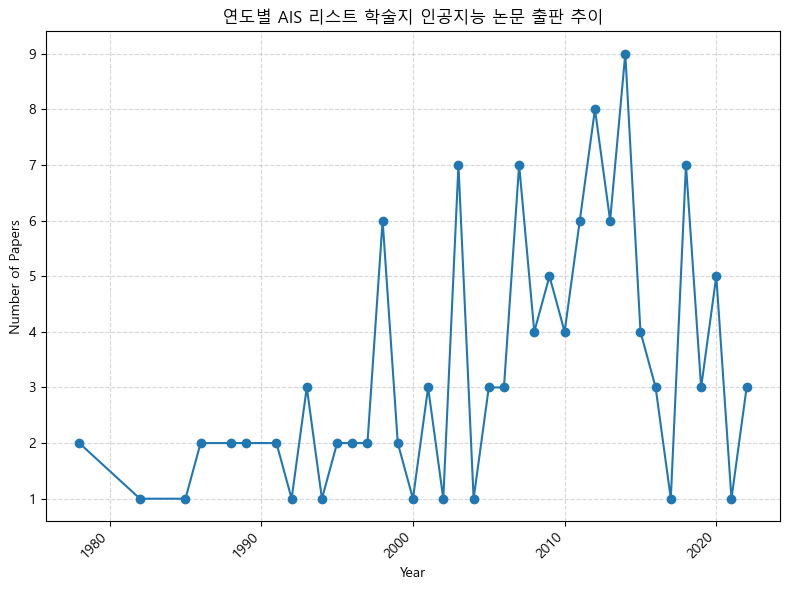

In [40]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정 (Windows, macOS, Linux에 따라 설정 방법이 다를 수 있음)
# 아래는 Windows용 예시이며, 다른 OS에서는 폰트 경로를 수정해야 할 수 있습니다.
font_path = "C:/Windows/Fonts/malgun.ttf"  # 예시: Malgun Gothic (맑은 고딕)
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name

# 'year' 열을 기준으로 논문 수 집계 (이전 코드와 동일)
year_counts = df_mis_top_journals['year'].value_counts().sort_index()

# 시각화 (선 그래프)
plt.figure(figsize=(8, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("연도별 AIS 리스트 학술지 인공지능 논문 출판 추이")  # 한글 제목
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
# 1. 연도(오름차순) 및 피인용수(내림차순) 기준으로 데이터프레임 정렬
#    이렇게 하면 각 연도 내에서 가장 인용 수가 높은 논문이 해당 연도의 첫 번째 행으로 오게 됩니다.
df_sorted = df_mis_top_journals.sort_values(by=['year', 'n_citation'], ascending=[True, False])

# 2. 'year' 열을 기준으로 중복된 행 제거, 첫 번째 행(가장 높은 인용수) 유지
#    drop_duplicates는 기본적으로 첫 번째 나타나는 행을 유지합니다.
top_cited_per_year = df_sorted.drop_duplicates(subset='year', keep='first').copy() # .copy() 사용 권장

# 3. 결과 확인 (연도 순으로 정렬되어 있음)
print("각 연도별 최고 인용 논문:")
# 주요 정보인 연도, 제목, 피인용수, 학술지만 출력해봅니다.
print(top_cited_per_year[['year', 'title', 'n_citation', 'venue']])

# 전체 데이터프레임을 보고 싶다면:
# print(top_cited_per_year)

각 연도별 최고 인용 논문:
         year                                              title  n_citation  \
3064519  1978  A management view of systems analysts: failure...          22   
757112   1982  Computer-aided modeling and analysis technique...           4   
1386057  1985  Documenting information systems for management...          30   
3031269  1986    Toward representing management-domain knowledge          43   
3031114  1988  The AI potential of model management and its c...          85   
2136376  1989  Perceived Chargeback System Fairness in Decent...          26   
1849312  1991  The management and control of written informat...          14   
1895851  1992  A model of competing interorganizational syste...          62   
1258210  1993  A comparative evaluation of the impact of elec...          89   
359878   1994  Artificial neural networks and their business ...         183   
123351   1995  Liquidity management with fuzzy qualitative co...          19   
700260   1996  Sustainab

In [16]:
top_cited_per_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 3064519 to 5021084
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              38 non-null     object
 1   title           38 non-null     object
 2   year            38 non-null     int64 
 3   n_citation      38 non-null     int64 
 4   venue           38 non-null     object
 5   keywords        38 non-null     object
 6   fos.name        38 non-null     object
 7   references      38 non-null     object
 8   title_lower     38 non-null     object
 9   keywords_lower  38 non-null     object
dtypes: int64(2), object(8)
memory usage: 3.3+ KB


In [17]:
l1_paper = top_cited_per_year

In [18]:
# 임시 컬럼 삭제
l1_paper = l1_paper.drop(['title_lower', 'keywords_lower'], axis=1)

# L1 열 추가하고 값 1로 설정
l1_paper['L1'] = 1

# 필터링 결과 확인
print(f"RAG와 경영 분야 키워드를 모두 포함하는 논문 수: {len(l1_paper)}")

RAG와 경영 분야 키워드를 모두 포함하는 논문 수: 38


In [19]:
file_name = 'l1_paper.parquet'

# 최종 경로 조합
output_path = os.path.join(base_dir, file_name)
l1_paper.to_parquet(output_path, index=False)

In [20]:
# L1 논문 처리
l1_ids = set(l1_paper['id'].values)

---
---
L2

In [21]:
# 1. L1 논문을 인용한 논문들 찾기 (L1이 피인용)
def get_papers_citing_l1(df):
    return df[df['references'].apply(lambda refs: bool(set(refs.tolist() if isinstance(refs, np.ndarray) else refs) & l1_ids))]

# 2. L1 논문이 인용한 논문들의 ID 찾기 (L1이 인용)
l1_cited_ids = set()
for _, row in l1_paper.iterrows():
    refs = row['references'].tolist() if isinstance(row['references'], np.ndarray) else row['references']
    l1_cited_ids.update(refs)

In [22]:
# L2 논문들 찾기
papers_citing_l1 = get_papers_citing_l1(df)  # L1을 인용한 논문들
papers_cited_by_l1 = df[df['id'].isin(l1_cited_ids)]  # L1이 인용한 논문들

# L2 논문들 합치기
l2_paper = pd.concat([papers_citing_l1, papers_cited_by_l1]).drop_duplicates(subset=['id'])
l2_paper['L2'] = 1

In [23]:
l2_paper.head()

,id,title,year,n_citation,venue,keywords,fos.name,references,title_lower,keywords_lower,L2
19789,53e997c1b7602d9701fae39a,Sharing knowledge,2008,78,Commun. ACM,"[group identification, knowledge-sharing behav...",[],"[53e9b33db7602d9703e1039a, 53e9ba64b7602d97046...",sharing knowledge,"[group identification, knowledge-sharing behav...",1
24283,53e997e3b7602d9701fd86f2,Hierarchical scaling of marketing decision sup...,1994,22,Decision Support Systems,"[MARKETING DECISION SUPPORT SYSTEMS, DECISION...","[Decision analysis, Marketing decision support...","[53e99991b7602d97021d827c, 53e9b661b7602d97041...",hierarchical scaling of marketing decision sup...,"[marketing decision support systems, decision...",1
25833,53e997e8b7602d9701fdfc69,Big Data Framework,2013,100,"Systems, Man, and Cybernetics","[hadoop paradigm, better data, large big data ...","[Data integration, Data science, Data warehous...","[53e9b954b7602d970453fb4a, 53e9be09b7602d9704a...",big data framework,"[hadoop paradigm, better data, large big data ...",1
30668,53e997f5b7602d9701ffa3a3,Knowledge Sourcing Effectiveness,2004,466,Management Science,"[general model, dispositional antecedent, nove...","[Survey data collection, Economics, Psychologi...","[53e99e14b7602d97026da200, 53e99e30b7602d97026...",knowledge sourcing effectiveness,"[general model, dispositional antecedent, nove...",1
34566,53e99800b7602d970200f476,Economics of Crime.,2006,113,Foundations and Trends in Microeconomics,"[network externality, economic value, customer...","[Customer relationship management, Customer re...","[53e9b0a5b7602d9703b0def4, 53e9bcadb7602d97049...",economics of crime.,"[network externality, economic value, customer...",1


In [24]:
# --- 데이터 및 키워드 전처리 ---
# title 열을 소문자로 변환 (NaN 값 처리 포함)
l2_paper['title_lower'] = l2_paper['title'].str.lower().fillna('')

# keywords 열 처리 (리스트 내 각 문자열 소문자 변환, NaN/빈 리스트 처리 필요시 추가)
# 여기서는 title만 사용하므로 keywords_lower 변환은 주석 처리하거나 생략 가능
# l2_paper['keywords_lower'] = l2_paper['keywords'].apply(lambda lst: [str(k).lower() for k in lst if pd.notna(k)] if isinstance(lst, list) else [])

# 키워드 리스트도 소문자로 변환
ai_keywords_lower = [k.lower() for k in ai_keywords]
mis_keywords_lower = [k.lower() for k in mis_keywords]

# --- 필터링 마스크 생성 ---
# AI 키워드 포함 여부 확인 (title 열)
# 각 title_lower 문자열(x)에 대해 ai_keywords_lower 중 하나라도 포함되면 True
ai_mask = l2_paper['title_lower'].apply(lambda x: any(keyword in x for keyword in ai_keywords_lower))

# MIS 키워드 포함 여부 확인 (title 열)
# 각 title_lower 문자열(x)에 대해 mis_keywords_lower 중 하나라도 포함되면 True
mis_mask = l2_paper['title_lower'].apply(lambda x: any(keyword in x for keyword in mis_keywords_lower))

# --- 마스크 결합 및 필터링 ---
# 두 마스크를 AND 연산(&)으로 결합 (AI 키워드와 MIS 키워드 모두 포함해야 True)
combined_mask = ai_mask | mis_mask

# 생성된 마스크를 사용하여 데이터프레임 필터링
l2_paper_filtered = l2_paper[combined_mask].copy() # .copy() 사용 권장

# --- 결과 확인 ---
print(f"총 {len(l2_paper_filtered)}개의 논문이 필터링되었습니다.")
print("필터링된 논문 샘플 (title):")
# 필터링된 논문의 title 열만 확인하여 키워드가 잘 포함되었는지 봅니다.
print(l2_paper_filtered['title'].head())

# 필터링된 데이터프레임 전체를 보고 싶다면:
# print(l2_paper_filtered)

총 1710개의 논문이 필터링되었습니다.
필터링된 논문 샘플 (title):
24283    Hierarchical scaling of marketing decision sup...
25833                                   Big Data Framework
60836         Avoiding Pitfalls in Neural Network Research
62606    Implementing knowledge management in supply ch...
63698    Trust, Power And Interorganizational Informati...
Name: title, dtype: object


In [25]:
l2_paper = l2_paper_filtered

In [26]:
# 결과 확인
print(f"L1(RAG) 논문 수: {len(l1_paper):,}")
print(f"L1을 인용한 논문 수: {len(papers_citing_l1):,}")
print(f"L1이 인용한 논문 수: {len(papers_cited_by_l1):,}")
print(f"L2(직접 연결된) 논문 총 수: {len(l2_paper):,}")

# L1이면서 L2인 논문 수 확인
l1_and_l2 = len(set(l1_paper['id']) & set(l2_paper['id']))
print(f"L1이면서 L2인 논문 수: {l1_and_l2:,}")

L1(RAG) 논문 수: 38
L1을 인용한 논문 수: 2,548
L1이 인용한 논문 수: 586
L2(직접 연결된) 논문 총 수: 1,710
L1이면서 L2인 논문 수: 12


In [27]:
# 결과 저장
file_name = 'l2_paper.parquet'

# 최종 경로 조합
output_path = os.path.join(base_dir, file_name)
l2_paper.to_parquet(output_path, index=False)

In [28]:
# L2 논문의 id 집합
l2_ids = set(l2_paper['id'].values)

---
---
L3

In [29]:
# L3만들기

# 1. L2 논문을 인용한 논문들 찾기
def get_papers_citing_l2(df):
    return df[df['references'].apply(lambda refs: bool(set(refs.tolist() if isinstance(refs, np.ndarray) else refs) & l2_ids))]

In [30]:
# 2. L2 논문이 인용한 논문들의 ID 찾기
l2_cited_ids = set()
for _, row in l2_paper.iterrows():
    refs = row['references'].tolist() if isinstance(row['references'], np.ndarray) else row['references']
    l2_cited_ids.update(refs)

# L3 논문들 찾기
papers_citing_l2 = get_papers_citing_l2(df)  # L2를 인용한 논문들
papers_cited_by_l2 = df[df['id'].isin(l2_cited_ids)]  # L2가 인용한 논문들

# L3 논문들 합치기
l3_paper = pd.concat([papers_citing_l2, papers_cited_by_l2]).drop_duplicates(subset=['id'])
l3_paper['L3'] = 1

# 결과 확인
print(f"L2 논문을 인용한 논문 수: {len(papers_citing_l2):,}")
print(f"L2가 인용한 논문 수: {len(papers_cited_by_l2):,}")
print(f"L3(L2와 직접 연결된) 논문 총 수: {len(l3_paper):,}")

L2 논문을 인용한 논문 수: 38,504
L2가 인용한 논문 수: 17,723
L3(L2와 직접 연결된) 논문 총 수: 52,315


In [31]:
# L1/L2/L3 중복 확인
l1_and_l3 = len(set(l1_paper['id']) & set(l3_paper['id']))
l2_and_l3 = len(set(l2_paper['id']) & set(l3_paper['id']))
print(f"\nL1이면서 L3인 논문 수: {l1_and_l3:,}")
print(f"L2이면서 L3인 논문 수: {l2_and_l3:,}")

# L3 논문 샘플 확인
print("\n=== L3 논문 샘플 ===")
sample_df = l3_paper[['title', 'year', 'references']].head()
for _, row in sample_df.iterrows():
    refs = row['references'].tolist() if isinstance(row['references'], np.ndarray) else row['references']
    l2_refs = set(refs) & l2_ids
    print(f"\nTitle: {row['title']}")
    print(f"Year: {row['year']}")
    print(f"Number of L2 papers cited: {len(l2_refs)}")


L1이면서 L3인 논문 수: 38
L2이면서 L3인 논문 수: 1,468

=== L3 논문 샘플 ===

Title: Design Trade-offs for Electronic Intermediaries.
Year: 2008
Number of L2 papers cited: 3

Title: The Impact of IT on Competitive Advantage: A Microeconomic Approachto Making the Resource-Based View Explicit.
Year: 2005
Number of L2 papers cited: 4

Title: An Overview of Cloud Computing Adoption Challenges in the Norwegian Context
Year: 2014
Number of L2 papers cited: 1

Title: An Empirical Investigation of Operational Business Intelligence Perspectives to Support an Analysis and Control of Business Processes
Year: 2015
Number of L2 papers cited: 3

Title: The Start of a Journey to the Cloud in the Developing World: A Case Study of Egypt
Year: 2015
Number of L2 papers cited: 1


In [32]:
# 결과 저장
file_name = 'l3_paper.parquet'
output_path = os.path.join(base_dir, file_name)
l3_paper.to_parquet(output_path, index=False)

---
---

In [33]:
# 데이터프레임 합치기
merged_df = pd.concat([l1_paper, l2_paper, l3_paper], axis=0)

# 중복된 행들에 대해 L 컬럼들의 값을 최대값으로 합치기 (1과 1이면 1로)
merged_df = merged_df.groupby(merged_df.index).agg({
    'id': 'first',
    'title': 'first',
    'year': 'first',
    'n_citation': 'first',
    'venue': 'first',
    'keywords': 'first',
    'fos.name': 'first',
    'references': 'first',
    'L1': 'max',  # 중복된 행의 L1 값 중 최대값 (0 or 1)
    'L2': 'max',  # 중복된 행의 L2 값 중 최대값 (0 or 1)
    'L3': 'max'   # 중복된 행의 L3 값 중 최대값 (0 or 1)
}).reset_index(drop=True)

# 없는 L 컬럼들은 0으로 채우기
merged_df['L1'] = merged_df['L1'].fillna(0)
merged_df['L2'] = merged_df['L2'].fillna(0)
merged_df['L3'] = merged_df['L3'].fillna(0)

In [34]:
merged_df.head()

,id,title,year,n_citation,venue,keywords,fos.name,references,L1,L2,L3
0,53e99e0cb7602d97026d141c,Microcomputer playfulness: development of a me...,1992,716,MIS Quarterly,"[workplace implication, microcomputer playfuln...","[Knowledge management, Computer training, Psyc...","[53e9a291b7602d9702b98e06, 53e9a914b7602d97032...",0.0,0.0,1.0
1,53e9a1b6b7602d9702aae9bb,Design Trade-offs for Electronic Intermediaries.,2008,4,Electronic Markets,"[business network, intermediary, electronic co...","[Intermediary, Transparency (graphic), Economi...","[53e99d2fb7602d97025e71a6, 53e9a5a1b7602d9702e...",0.0,0.0,1.0
2,53e9aafab7602d970347d65e,The Impact of IT on Competitive Advantage: A M...,2005,0,ECIS,[competitive advantage],"[Resource-based view, Computer science, Compet...","[53e999d9b7602d9702220f7c, 53e99b9bb7602d97024...",0.0,0.0,1.0
3,5536867d0cf2dbb77a816a44,An Overview of Cloud Computing Adoption Challe...,2014,11,UCC '14 Proceedings of the 2014 IEEE/ACM 7th I...,"[adoption, security, law, cloud computing, org...","[Norwegian, Public relations, Normative, Cloud...","[53e9a487b7602d9702da4125, 53e9a13fb7602d9702a...",0.0,0.0,1.0
4,55465edc0cf2939c2feecc43,An Empirical Investigation of Operational Busi...,2015,0,System Sciences,"[business data processing, competitive intelli...","[Artifact-centric business process model, Busi...","[53e997f5b7602d9701ff904f, 53e99a43b7602d97022...",0.0,0.0,1.0


In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52557 entries, 0 to 52556
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          52557 non-null  object 
 1   title       52557 non-null  object 
 2   year        52557 non-null  int64  
 3   n_citation  52557 non-null  int64  
 4   venue       52557 non-null  object 
 5   keywords    52557 non-null  object 
 6   fos.name    52557 non-null  object 
 7   references  52557 non-null  object 
 8   L1          52557 non-null  float64
 9   L2          52557 non-null  float64
 10  L3          52557 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 4.4+ MB


In [36]:
# 결과 저장
file_name = 'l123_paper.parquet'
output_path = os.path.join(base_dir, file_name)
merged_df.to_parquet(output_path, index=False)

In [37]:
import pandas as pd
import numpy as np
import re

# -------------------- 노드 파일 생성 --------------------
def clean_text(text):
    if isinstance(text, str):
        # 알파벳, 숫자, 공백을 제외한 모든 문자를 공백으로 변환
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        # 연속된 공백을 하나의 공백으로 변환
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    return str(text)

def clean_list(lst):
    if isinstance(lst, np.ndarray):
        lst = lst.tolist()
    if isinstance(lst, str):
        try:
            lst = eval(lst)
        except:
            return ''
    if isinstance(lst, list):
        # 각 항목에서 특수문자를 공백으로 변환
        cleaned = [clean_text(str(item)) for item in lst if item]
        return ' | '.join(cleaned)
    return ''

# 노드 데이터 생성
def create_node_file(df, output_path='gephi_nodes.csv'):
    # 노드 기본 정보
    nodes = df[['id', 'title', 'year', 'n_citation']].copy()
    nodes.columns = ['Id', 'Label', 'Year', 'Citations']
    
    # Label 정제
    nodes['Label'] = nodes['Label'].apply(clean_text)
    
    # 추가 속성
    nodes['Research_Fields'] = df['fos.name'].apply(clean_list)
    nodes['Keywords'] = df['keywords'].apply(clean_list)
    
    # Level 정보 추가
    nodes['Level'] = df.apply(lambda row: 
        'L1' if row.get('L1') == 1 else 
        'L2' if row.get('L2') == 1 else 
        'L3' if row.get('L3') == 1 else 'Other', axis=1)
    
    # CSV 파일로 저장
    nodes.to_csv(output_path, index=False, encoding='utf-8-sig', quoting=1)
    
    print(f"노드 파일이 생성되었습니다: {output_path}")
    print(f"총 노드 수: {len(nodes)}")
    
    return nodes

# -------------------- 엣지 파일 생성 --------------------
def create_edge_file(df, output_path='gephi_edges.csv', bidirectional=False):
    # 엣지 리스트를 저장할 빈 리스트 생성
    edges = []
    node_ids = set(df['id'].values)  # 노드 ID 집합 (선택적 필터링용)
    
    # 각 논문에 대해 엣지 생성
    for idx, row in df.iterrows():
        source_id = row['id']
        refs = row['references']
        
        # references가 None이면 건너뛰기
        if refs is None:
            continue
        
        try:
            # NumPy 배열인 경우 리스트로 변환
            if isinstance(refs, np.ndarray):
                refs = refs.tolist()
            # 문자열인 경우 리스트로 변환 시도
            elif isinstance(refs, str):
                if refs.startswith('[') and refs.endswith(']'):
                    refs_str = refs.strip('[]')
                    if refs_str:
                        refs = [ref.strip().strip('\'\" ') for ref in refs_str.split(',')]
                    else:
                        refs = []
                else:
                    refs = [refs]  # 단일 문자열을 리스트로
            
            # 다른 타입이거나 리스트가 아니면 빈 리스트로
            if not isinstance(refs, list):
                refs = []
                
            # 각 참조 논문에 대해 엣지 생성
            for ref in refs:
                # 문자열이 아니면 문자열로 변환
                if not isinstance(ref, str):
                    ref = str(ref)
                
                ref = ref.strip().strip('\'\" ')
                
                # 빈 문자열이면 건너뛰기
                if not ref:
                    continue
                
                # 양방향 엣지 생성 옵션
                if bidirectional:
                    edges.append({
                        'Source': source_id,
                        'Target': ref,
                        'Type': 'Cites'  # A가 B를 인용
                    })
                    edges.append({
                        'Source': ref,
                        'Target': source_id,
                        'Type': 'Cited by'  # B가 A에 의해 인용됨
                    })
                else:
                    edges.append({
                        'Source': source_id,
                        'Target': ref,
                        'Type': 'Directed',
                        'Weight': 1
                    })
                
        except Exception as e:
            print(f"행 처리 중 오류 (ID {source_id}): {e}")
            continue
    
    # 엣지가 없으면 빈 데이터프레임 반환
    if not edges:
        print("생성된 엣지가 없습니다.")
        return pd.DataFrame()
    
    # 엣지 리스트를 데이터프레임으로 변환
    edge_df = pd.DataFrame(edges)
    
    # 중복 제거
    edge_df = edge_df.drop_duplicates(['Source', 'Target'])
    
    # CSV 파일로 저장
    edge_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    # 통계 출력
    print(f"엣지 파일이 생성되었습니다: {output_path}")
    print(f"총 엣지 수: {len(edge_df)}")
    print(f"Source 노드 수: {len(edge_df['Source'].unique())}")
    print(f"Target 노드 수: {len(edge_df['Target'].unique())}")
    
    return edge_df

# -------------------- 실행 코드 --------------------
# 노드 파일 생성
node_df = create_node_file(merged_df, 'C:/Project/RAG연구동향분석/250409/gephi_nodes.csv')

# References 열 샘플 확인
print("\nReferences 열 샘플 확인:")
sample_refs = merged_df['references'].iloc[0]
print(f"타입: {type(sample_refs)}")
print(f"값: {sample_refs}")

# 단방향 엣지 파일 생성
print("\n단방향 엣지 파일 생성 중...")
edge_df = create_edge_file(merged_df, 'C:/Project/RAG연구동향분석/250409/gephi_edges.csv', bidirectional=False)

# 결과 분석
if not edge_df.empty:
    # 노드 ID와 엣지에 포함된 노드 ID 비교
    node_ids = set(node_df['Id'])
    edge_nodes = set(edge_df['Source'].unique()) | set(edge_df['Target'].unique())
    
    print("\n노드-엣지 비교:")
    print(f"노드 파일의 고유 노드 수: {len(node_ids)}")
    print(f"엣지 파일에 포함된 고유 노드 수: {len(edge_nodes)}")
    print(f"노드 파일에 있으나 엣지에 없는 노드 수: {len(node_ids - edge_nodes)}")
    
    # 엣지 데이터 샘플 확인
    print("\n엣지 데이터 샘플 (처음 5개):")
    print(edge_df.head())

노드 파일이 생성되었습니다: C:/Project/RAG연구동향분석/250409/gephi_nodes.csv
총 노드 수: 52557

References 열 샘플 확인:
타입: <class 'numpy.ndarray'>
값: ['53e9a291b7602d9702b98e06' '53e9a914b7602d9703264507'
 '53e9b0abb7602d9703b15648' '53e9b46fb7602d9703f6fef4'
 '53e9b48fb7602d9703f998f7' '53e9bbd4b7602d9704824081'
 '555045fe45ce0a409eb5b1a4']

단방향 엣지 파일 생성 중...
엣지 파일이 생성되었습니다: C:/Project/RAG연구동향분석/250409/gephi_edges.csv
총 엣지 수: 955417
Source 노드 수: 52557
Target 노드 수: 292069

노드-엣지 비교:
노드 파일의 고유 노드 수: 52557
엣지 파일에 포함된 고유 노드 수: 312194
노드 파일에 있으나 엣지에 없는 노드 수: 0

엣지 데이터 샘플 (처음 5개):
                     Source                    Target      Type  Weight
0  53e99e0cb7602d97026d141c  53e9a291b7602d9702b98e06  Directed       1
1  53e99e0cb7602d97026d141c  53e9a914b7602d9703264507  Directed       1
2  53e99e0cb7602d97026d141c  53e9b0abb7602d9703b15648  Directed       1
3  53e99e0cb7602d97026d141c  53e9b46fb7602d9703f6fef4  Directed       1
4  53e99e0cb7602d97026d141c  53e9b48fb7602d9703f998f7  Directed       1
